# Estimate exposure time

In [18]:
!wget https://github.com/fcangemi/gp-tools-svom/raw/main/ECL-RSP-ARF_20211023T01.fits
!wget https://github.com/fcangemi/gp-tools-svom/raw/main/MXT_FM_PANTER_FULL-ALL-1.0.arf

--2022-11-30 16:38:14--  https://github.com/fcangemi/gp-tools-svom/raw/main/ECL-RSP-ARF_20211023T01.fits
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/fcangemi/gp-tools-svom/main/ECL-RSP-ARF_20211023T01.fits [following]
--2022-11-30 16:38:15--  https://raw.githubusercontent.com/fcangemi/gp-tools-svom/main/ECL-RSP-ARF_20211023T01.fits
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25920 (25K) [application/octet-stream]
Saving to: 'ECL-RSP-ARF_20211023T01.fits'

ECL-RSP-ARF_2021102 100%[===================>]  25.31K  --.-KB/s    in 0.001s  

2022-11-30 16:38:15 (26.8 MB/s) - 'ECL-RSP-ARF_202110

In [19]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from scipy import constants as c
from scipy.optimize import curve_fit

In [20]:
def read_arf(arf_filename):
    hdu1 = fits.open(arf_filename)
    arf_data=hdu1[1].data
    
    emin = arf_data.ENERG_LO
    emax = arf_data.ENERG_HI
    arf = arf_data.SPECRESP

    dE = emax - emin
    E = emin + (emax - emin) / 2

    return E, emin, emax, dE, arf

def function(x, a):
    return np.exp(- a * 1.5 / x ** 3)

def absorption():
    # From Strom & Strom 1961
    data = np.genfromtxt("absorption.txt", unpack = True, delimiter = ",",
                        skip_header = 1)
    wavelength = data[0]
    tau = data[1]
    norm_I = data[2]
    E = c.h * c.speed_of_light / (wavelength * 1e-10) * 6.242e15 # energy in keV
    plt.plot(E, norm_I, label = "data")
    plt.yscale("log")
    
    # Fit
    params, covs = curve_fit(function, E, norm_I, p0 = [0.50])
    print("params: ", params)
    
    plt.plot(E, function(E, params[0]), label = "Best fit")
    plt.ylim([1e-4, 1e1])
    plt.legend()
    plt.xlim([0, 2])

def plot_F(ax, E, F):
    ax.plot(E, F, color = "black", linewidth = 3)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Energy [keV]")
    ax.set_ylabel("F(E) [ph/cm2/s/keV]")

def plot_EF(ax, E, EF):
    ax.plot(E, EF, color = "black", linewidth = 3)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Energy [keV]")
    ax.set_ylabel("EF(E) [ph/cm2/s]")

def calculate_norm_from_flux(flux, Gamma, Emin, Emax):
    return flux * (-Gamma + 2) / (Emax**(-Gamma + 2) - Emin**(-Gamma + 2)) * 6.242e8

def calculate_countrate(norm, Gamma, n_H, Eband, instrument, model):
    if(instrument == "MXT"):
        E, emin, emax, dE, arf = read_arf("MXT_FM_PANTER_FULL-ALL-1.0.arf")
    else:
        E, emin, emax, dE, arf = read_arf("ECL-RSP-ARF_20211023T01.fits")

    if((Eband[0] <= E[0] - dE[0]) or (Eband[-1] >= E[-1] + dE[-1])):
        print("ERROR: energy band outside the arf energy range !")
    else:
        E_r = E[(E>=Eband[0]) & (E<=Eband[1])]
        dE_r = dE[(E>=Eband[0]) & (E<=Eband[1])]
        arf_r = arf[(E>=Eband[0]) & (E<=Eband[1])]
        emax_r = emax[(E>=Eband[0]) & (E<=Eband[1])]
        emin_r = emin[(E>=Eband[0]) & (E<=Eband[1])]
        
        a = 0.286733
        
        if(model == "powerlaw"):
            F = norm * E_r**(-Gamma) * np.exp(- n_H * a / E_r**3)
            countrate = sum(arf_r * norm * E_r**(-Gamma) * np.exp(- n_H * a / E_r**3) * dE_r)
            
        elif(model == "cutoffpl"):
            F = norm * E_r**(-Gamma) * np.exp(-E_r / E_cut) * np.exp(- n_H * a / E_r**3)
            countrate = sum(arf_r * norm * E_r**(-Gamma) * np.exp(-E_r / E_cut) * np.exp(- n_H * a / E_r**3) * dE_r)
            
        else: # Brokenpowerlaw
            F = np.ones(len(E_r))
            countrate = 0
            for i in range(len(E_r)):
                if(E_r[i] <= E_break):
                    F[i] = norm * E_r[i]**(-alpha) * np.exp(- n_H * a / E_r[i]**3)
                    countrate += arf_r[i] * norm * E_r[i]**(-alpha) * np.exp(- n_H * a / E_r[i]**3) * dE_r[i]
                    
                else:
                    F[i] = norm * E_r[i]**(-beta) * E_break**(beta - alpha) * np.exp(- n_H * a / E_r[i]**3)
                    countrate += arf_r[i] * norm * E_r[i]**(-beta) * E_break**(beta - alpha) * dE_r[i] * np.exp(- n_H * a / E_r[i]**3)
                                    
        plt.plot(E_r, F, color = "red", linewidth = 2, label = "Source")
        plt.xscale("log")
        plt.yscale("log")
        plt.xlabel("Energy [keV]")
        plt.ylabel("ph/cm2/s/keV")
        return countrate

def calculate_background(instrument, Eband):
    if(instrument == "ECLAIRs"):
        E, emin, emax, dE, arf = read_arf("ECL-RSP-ARF_20211023T01.fits")
    else:
        E, emin, emax, dE, arf = read_arf("MXT_FM_PANTER_FULL-ALL-1.0.arf")
        
    if((Eband[0] <= E[0] - dE[0]) or (Eband[-1] >= E[-1] + dE[-1])):
        print("ERROR: energy band outside the arf energy range !")
    else:
        E_r = E[(E>=Eband[0]) & (E<=Eband[1])]
        dE_r = dE[(E>=Eband[0]) & (E<=Eband[1])]
        arf_r = arf[(E>=Eband[0]) & (E<=Eband[1])]
        emax_r = emax[(E>=Eband[0]) & (E<=Eband[1])]
        emin_r = emin[(E>=Eband[0]) & (E<=Eband[1])]
        
        if(instrument == "ECLAIRs"):
            # 2SJPL Model from Moretti+2009
            Gamma_1 = 1.4
            Gamma_2 = 2.88
            E_B = 29             # keV
            norm = 0.109         # ph/cm2/s/keV/sr
            F = norm / ((E_r / E_B)**(Gamma_1) + (E_r / E_B)**(Gamma_2))
            countrate = sum(arf_r / (0.24 * 1024) * 0.16 * 0.3436 * 80 * 80 * norm / ((E_r / E_B)**(Gamma_1) + (E_r / E_B)**(Gamma_2)) * dE_r)
            
        else:
            # Powerlaw Model from Moretti+2009
            norm = 3.67e-3 * 65318 * (13.5*0.0002777)**2 #norm in ph/cm2/s/keV/deg2 * nb pixel contributing to the PSF * (13.5 arcsec/pixel)**2
            Gamma = 1.47
            F = norm * E_r**(-Gamma)
            countrate = sum(arf_r * norm * E_r**(-Gamma) * dE_r)

        plt.plot(E_r, F, color = "blue", label = "CXB")
        plt.legend()
    return countrate

def calculate_exposure(SNR, instrument, Eband):
    print("Emin  = ", Eband[0], "keV")
    print("Emax  = ", Eband[1], "keV")
    print("norm  = ", f'{norm:.4f}', "ph/s/cm2/keV")
    
    if(model == "powerlaw"):
        print("Gamma = ", Gamma)
    elif(model == "bknpowerlaw"):
        print("alpha = ", alpha)
        print("beta  = ", beta)
        print("E_break = ", E_break, "keV")
    else:
        print("Gamma = ", Gamma)
        print("E_cut = ", E_cut)
    print("n_H   = ", n_H, "e21 cm-2")
    
    source = calculate_countrate(norm, Gamma, n_H, Eband, instrument, model)
    if(instrument == "MXT"):
        
        background = calculate_background("MXT", Eband)
        exposure = (SNR  / source * np.sqrt(source + background))**2
    else:
        background = calculate_background("ECLAIRs", Eband)
        exposure = (SNR  / source * np.sqrt(source / 0.4 + background))**2 # Skinner+2008
    
    print("Background =", f'{background:.4f}', "c/s in the energy band", Eband, "keV.")
    print("Source =", f'{source:.4f}', "c/s in the energy band", Eband, "keV.")
    print(instrument, ": need an exposure time of", f'{exposure:.2f}', "seconds for a SNR =", SNR, "over the energy band", Eband, "keV.")

This notebook uses ancillary response files of MXT and ECLAIRs in order to calculate the exposure time needed to achieve a signal to noise ratio given the spectrum of a source.
#### 1) Choose the type of model you want to use and define the parameters
**Three types** of models can be used: 

##### Simple powerlaw, "**powerlaw**":
$$
N(E) = \phi_0 E^{-\Gamma}
$$
- $\phi_0$: flux normalization in **ph/cm2/s/keV**, named "**norm**" in this notebook;
- $\Gamma$: photon index, named "**Gamma**" in this notebook.

**NB**: for this model, you can alternatively calculate the flux normalization $\phi_0$ by calling **calculate_norm_from_flux(unabsorbed_flux, Gamma, Emin, Emax)** and giving the ***unabsorbed flux*** in **ergs/cm2/s** between **Emin keV** and **Emax keV**.

##### Broken powerlaw, "**bknpowerlaw**":
$$
N(E) = \left\{
    \begin{array}{ll}
        \phi_0 E^{-\alpha} & \mbox{if } E \leq E_\mathrm{break} \\
        \phi_0 E_\mathrm{break}^{\beta-\alpha} E^{-\beta} & \mbox{if } E > E_\mathrm{break}
    \end{array}
\right.
$$
- $\phi_0$: flux normalization in **ph/cm2/s/keV**, named "**norm**" in this notebook;
- $E_\mathrm{break}$: break energy in **keV**, named "**E_break**" in this notebook;
- $\alpha$: photon index of the low energy powerlaw, named "**alpha**" in this notebook;
- $\beta$: photon index of the high energy powerlaw, named "**beta**" in this notebook.

##### Cutoff powerlaw, "**cutoffpl**":
$$
N(E) = \phi_0 E^{-\Gamma} e^\frac{E}{E_\mathrm{cut}} 
$$
- $\phi_0$: flux normalization in **ph/cm2/s/keV**, named "**norm**" in this notebook;
- $\Gamma$: photon index, named "**Gamma**" in this notebook;
- $E_\mathrm{cut}$: cutoff energy in **keV**, "**E_cut**" in this notebook.

`For the three models, absorption is taken into account thanks to the hydrogen density column parameter **n_H**, in **$10^{21}$cm$^{-2}$**.`
#### 2) Calculate the exposure
Once you have defined your model and the corresponding parameters, you can call "**calculate_exposure(SNR, instrument, Eband)**" to calculate the exposure time needed. This function has three arguments:
- "**SNR**": Signal to Noise Ratio;
- "**instrument**": you can choose between "MXT" or "ECLAIRs";
- "**Eband**": energy band for which you want to calculate the exposure time, [**Emin**, **Emax**], **Emin** and **Emax** in **keV**.


### Few examples
#### Powerlaw (example for the Crab)

Emin  =  4 keV
Emax  =  150 keV
norm  =  10.0000 ph/s/cm2/keV
Gamma =  2.1
n_H   =  4.5 e21 cm-2
Background = 3587.2578 c/s in the energy band [4, 150] keV.
Source = 523.9236 c/s in the energy band [4, 150] keV.
ECLAIRs : need an exposure time of 1.78 seconds for a SNR = 10 over the energy band [4, 150] keV.


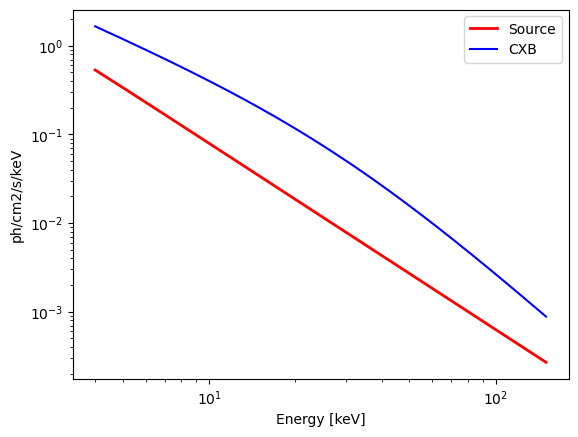

In [22]:
# Model and parameters
model = "powerlaw"
norm  = 10         # Flux normalisation in ph/cm2/s/keV
Gamma = 2.1        # Photon index
n_H   = 4.5        # Density column in 1e21 cm-2

# Exposure time
calculate_exposure(SNR = 10, instrument = "ECLAIRs", Eband = [4, 150])

Alternatively, you can give the unabsorbed flux to calculate the flux normalization:

In [ ]:
unabsorbed_flux = 2.24e-8   # Unabsorbed flux in ergs/cm2/s between 2-10 keV
norm = calculate_norm_from_flux(unabsorbed_flux, Gamma, 2, 10)
calculate_exposure(SNR = 5, instrument = "MXT", Eband = [0.2, 10])

#### Broken Powerlaw

Emin  =  4 keV
Emax  =  150 keV
norm  =  0.1000 ph/s/cm2/keV
alpha =  1.3
beta  =  2.6
E_break =  30 keV
n_H   =  2.0 e21 cm-2
Background = 3587.2578 c/s in the energy band [4, 150] keV.
Source = 36.3873 c/s in the energy band [4, 150] keV.
ECLAIRs : need an exposure time of 2500.24 seconds for a SNR = 30 over the energy band [4, 150] keV.


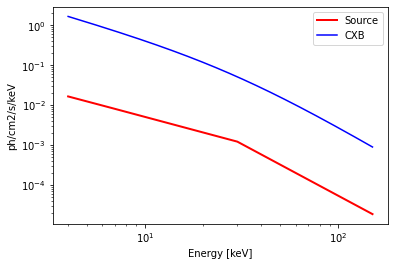

In [158]:
model   = "bknpowerlaw"
norm    = 0.1           # Flux normalisation in ph/cm2/s/keV
E_break = 30            # Break energy in keV
alpha   = 1.3           # Photon index of the low energy powerlaw
beta    = 2.6           # Photon index of the high energy powerlaw
n_H     = 2.0           # Density column in 1e21 cm-2
calculate_exposure(SNR = 30, instrument = "ECLAIRs", Eband = [4, 150])

#### Cutoff Powerlaw

Emin  =  4 keV
Emax  =  100 keV
norm  =  0.1000 ph/s/cm2/keV
Gamma =  1.7
E_cut =  40
n_H   =  0 e21 cm-2
Background = 3569.5199 c/s in the energy band [4, 100] keV.
Source = 9.5452 c/s in the energy band [4, 100] keV.
ECLAIRs : need an exposure time of 3943.98 seconds for a SNR = 10 over the energy band [4, 100] keV.


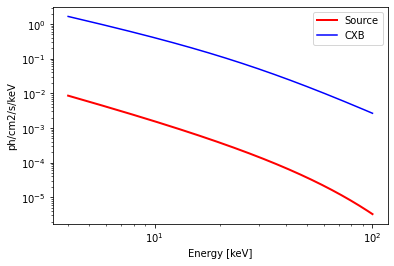

In [160]:
model = "cutoffpl"
norm  = 0.1         # Flux normalisation in ph/cm2/s/keV
E_cut = 40          # Energy cutoff in keV
Gamma = 1.7         # Photon index
n_H   = 0           # Density column in 1e21 cm-2
calculate_exposure(SNR = 10, instrument = "ECLAIRs", Eband = [4, 100])